In [1]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon
from pathlib import Path
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd
import pyproj
import fiona
import boto3

In [2]:
directory = Path.cwd()
str_dir = str(directory)
clean_path = str_dir.replace('Tutorials', '')
print(clean_path)

C:\Users\ryane\Documents\Github\ladi-tutorial\


### Here we read in the Natural Earth data so that we can plot our images and states:

In [3]:
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
file = Path(str(clean_path) + '/data/Natural-Earth/ne_10m_admin_1_states_provinces.shp')
natural_earth = gpd.read_file(file)
natural_earth.crs = fiona.crs.from_epsg(4326)

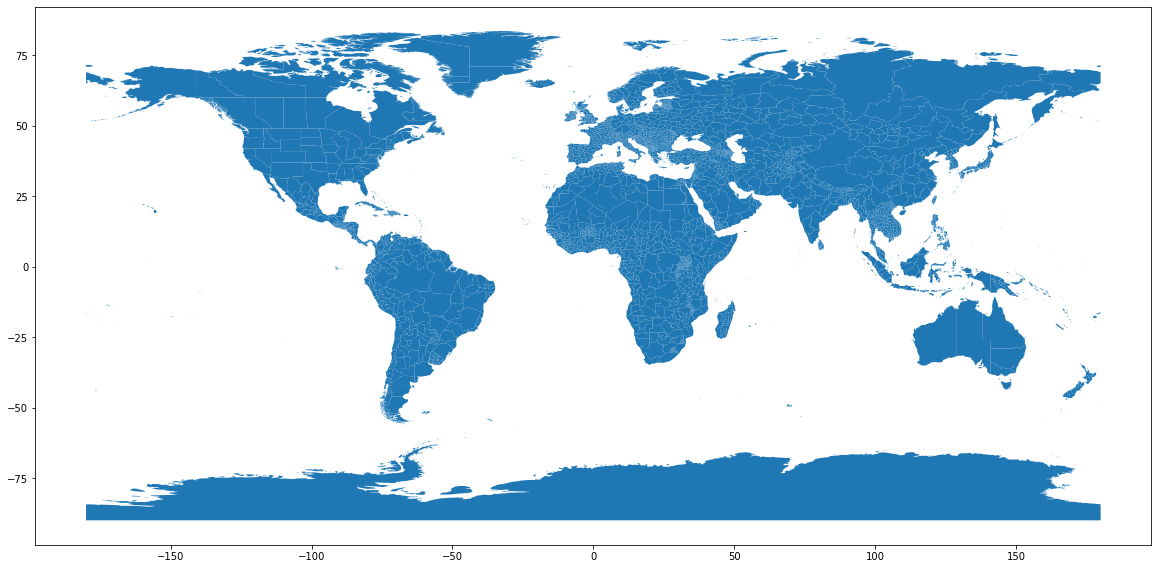

In [4]:
ax = natural_earth.plot(figsize=(20,20))

### Here we read in the image metadata and human aggregated response data from LADI's AWS bucket (specifically those with a 'flood' or 'damage' label):

In [5]:
bucket_name = 'ladi'
file_1_path = 'Labels/ladi_images_metadata.csv'
client = boto3.client('s3')

In [6]:
obj_1 = client.get_object(Bucket = bucket_name, Key = file_1_path)

image_metadata = pd.read_csv(obj_1['Body'])
image_metadata_renamed = image_metadata.rename(columns={"uuid": "image_uuid"})
image_metadata_clean = image_metadata_renamed.dropna()

latitude = image_metadata_clean['gps_lat'].tolist() 
longitude = image_metadata_clean['gps_lon'].tolist()

#This line converts the DF to a GDF and sets the proper crs
image_metadata_gdf = GeoDataFrame(image_metadata_clean, crs=fiona.crs.from_epsg(4326), geometry=gpd.points_from_xy(longitude, latitude))

In [7]:
#################### CLEAN AND VALIDATE LADI HUMAN LABELS #########################
human_label_filepath = "Labels/ladi_aggregated_responses_url.tsv"
obj_2 = client.get_object(Bucket = bucket_name, Key = human_label_filepath)
human_label_file = pd.read_csv(obj_2['Body'],sep = '\t' )

#STRIP OFF BRACKET AND COMMA FROM THE ANSWER CATEGORY
human_label_file["Answer"] = human_label_file["Answer"].str.strip('[|]')
human_label_file["Answer"] = human_label_file["Answer"].str.split(",",expand = True)

#EXTRACT LABELS WITH DAMAGE AND INFRASTRUCTURE CATEGORIES AND REMOVE THOSE LABELED 'NONE'
label_damage_infra = human_label_file[human_label_file['Answer'].str.contains('damage|infrastructure',na=False,case=False)]
label_clean = label_damage_infra[~label_damage_infra['Answer'].str.contains('none',na=False,case=False)]
human_flood_label = label_clean[label_clean['Answer'].str.contains('flood',na=False,case=False)]
human_damage_label = label_clean[label_clean['Answer'].str.contains('damage',na=False,case=False)]

### Functions:

In [8]:
def merger(df, gdf, what_on): 
    
    '''merger merges a given DataFrame with the given GeoDataFrame such as image_metadata_gdf on 
       whatever column they choose, so that we can plot these dataframes'''
    
    merged_df = gdf.merge(df, on=what_on)
    gdf = GeoDataFrame(merged_df, crs=fiona.crs.from_epsg(4326))
    
    return(gdf)

In [9]:
def state_finder(df):  
    
    '''state_finder performs a spacial join with the states
       shapefile to find which state points are plotted in'''
    
    label_by_state = gpd.sjoin(df, states, op='within')
    label_by_state = label_by_state.drop(columns=['index_right'])
    
    return(label_by_state)

In [10]:
def images_per_state(timestamp):

    '''images_per_states counts how many images were taken in each state for 
       the given timeframe above (states not printed if they have no images):'''

    state_counter = {}
    state_names = []

    for i in timestamp.name_en:
        state_names.append(i)

    for i in state_names:
        if i not in state_counter:
            state_counter[i] = state_names.count(i)

    return(state_counter)

In [11]:
def categories(state_counter):
    
    '''state_counter takes the values above, finds the highest value
       and divides that by three to create numerical categories for states'''

    max_value=0
    for i in state_counter.values():
        if i > max_value:
            max_value = i

    low = int(max_value / 3)
    mid = int(low * 2)
    high = int(max_value)

    return(low, mid, high)

In [12]:
def state_category_splitter(low, mid, high, state_counter):
    
    '''state_category_splitter places each state into an array based on the number of 
       images within that state and the predetermined low, mid, and high values'''
    
    low_states = []
    mid_states = []
    high_states = []

    for i in state_counter.keys():
        val = state_counter.get(i)
        if val <= low:
            low_states.append(i)
        if val > low and val < high:
            mid_states.append(i)
        if val >= high:
            high_states.append(i)

    return(low_states, mid_states, high_states)

In [13]:
def state_dictionary_counter(low, mid, high, state_counter):

    low_states_count = {}
    mid_states_count = {}
    high_states_count = {}

    for i in state_counter.keys():
        val = state_counter.get(i)
        if val <= low:
            low_states_count[i] = val
        if val > low and val < high:
            mid_states_count[i] = val
        if val >= high:
            high_states_count[i] = val

    return(print('Low: ', low_states_count, '\n\n\nMid: ', mid_states_count, '\n\n\nHigh: ', high_states_count))

In [14]:
def state_plotter(gdf, timeframe):
    
    '''state_plotter The followi function will calculate the number of images in each US State,
       given a GeoDataFrame and a timeframe (e.g. year: '2018', month: '2018-10').
       It will then generate a map with each USA state color coded based on the number of images.'''  
    
    # Merge any DataFrame with states to find what state images were taken in
    state_gdf = state_finder(gdf)
    
    # Determines what images in the GeoDataFrame were taken during the given timeframe e.g.(timeframe: '2018', month: '2018-10')
    state_timestamp_gdf = state_gdf[state_gdf['timestamp'].str.contains(timeframe, na=False, case=True)]
    
    # Count the number of images in each state, find the highest value, and divide that by three to categorize each state
    count = images_per_state(state_timestamp_gdf)
    temp = categories(count)

    # split the states into different arrays based on the number of images within that state
    arrays = state_category_splitter(temp[0], temp[1], temp[2], count)
    state_dictionary_counter(temp[0], temp[1], temp[2], count)
    low_states = arrays[0]
    mid_states = arrays[1]
    high_states = arrays[2]

    # Make each of the arrays into DataFrames so they can be merged with states
    low_states_df = pd.DataFrame(low_states, columns=['name'])
    mid_states_df = pd.DataFrame(mid_states, columns=['name'])
    high_states_df = pd.DataFrame(high_states, columns=['name'])

    # Now we will make a GDF from each of the arrays so that each state can be plotted based on their number of images:
    low_states_gdf = merger(low_states_df, states, 'name')
    mid_states_gdf = merger(mid_states_df, states, 'name')
    high_states_gdf = merger(high_states_df, states, 'name')

    # Now that we have the states split up into their seperate GeoDataFrames we can plot each their own color:
    ax = low_states_gdf.plot(figsize=(20,20), color='green', alpha=.7, edgecolor='black')
    mid_states_gdf.plot(ax=ax, figsize=(20,20), color='yellow', alpha=.7, edgecolor='black')
    high_states_gdf.plot(ax=ax, figsize=(20,20), color='red', alpha=.7, edgecolor='black')
    ctx.add_basemap(ax, crs = fiona.crs.from_epsg(4326))
    
    return (plt.show())

In [15]:
states = natural_earth[natural_earth.iso_a2 == 'US'] #filters map down to just US States

## image_metadata_gdf map:

Low:  {'Alabama': 11, 'South Carolina': 36, 'Louisiana': 521, 'Georgia': 32, 'West Virginia': 75, 'Florida': 824, 'Virginia': 270, 'Wisconsin': 2025, 'Vermont': 128, 'Massachusetts': 1298, 'Oregon': 1250, 'Minnesota': 197, 'Maryland': 114, 'Mississippi': 1327, 'Montana': 19, 'North Dakota': 1929, 'Nebraska': 1160, 'New Mexico': 72, 'Kentucky': 737, 'Ohio': 1085, 'Arizona': 125, 'Michigan': 557, 'New Hampshire': 847, 'Delaware': 20, 'Iowa': 1416, 'Maine': 934, 'New York': 651, 'Rhode Island': 28, 'Connecticut': 241, 'Washington': 1035, 'Missouri': 1707, 'Tennessee': 1113, 'New Jersey': 154, 'South Dakota': 88, 'Colorado': 331, 'Pennsylvania': 340, 'Idaho': 29} 


Mid:  {'Texas': 2631, 'California': 2564, 'North Carolina': 2345, 'Indiana': 2894, 'Oklahoma': 3470, 'Illinois': 3436, 'Kansas': 3328, 'Nevada': 3640} 


High:  {'Arkansas': 6845}


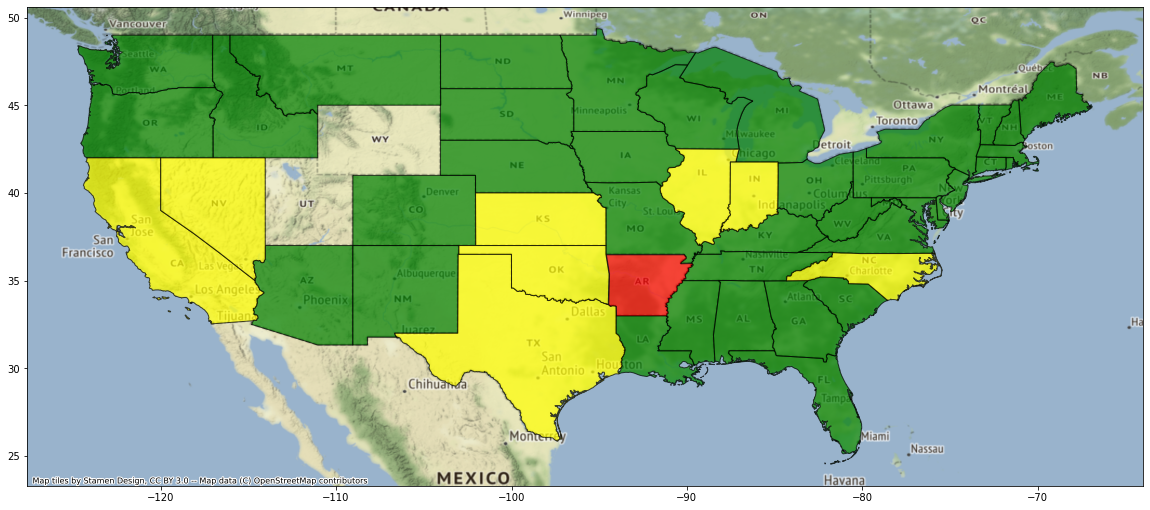

In [16]:
state_plotter(image_metadata_gdf, '2019')

## human_labeled_floods map:

In [17]:
human_labeled_floods = merger(human_flood_label, image_metadata_gdf, 'url')

Low:  {'Georgia': 3, 'Virginia': 3, 'Oklahoma': 8, 'Arkansas': 34, 'Indiana': 2, 'Tennessee': 1, 'Kentucky': 2, 'Iowa': 11, 'Illinois': 10, 'Nebraska': 4, 'Kansas': 18, 'North Dakota': 11} 


Mid:  {'Texas': 78, 'Florida': 89, 'Louisiana': 72, 'North Carolina': 92} 


High:  {'Mississippi': 106}


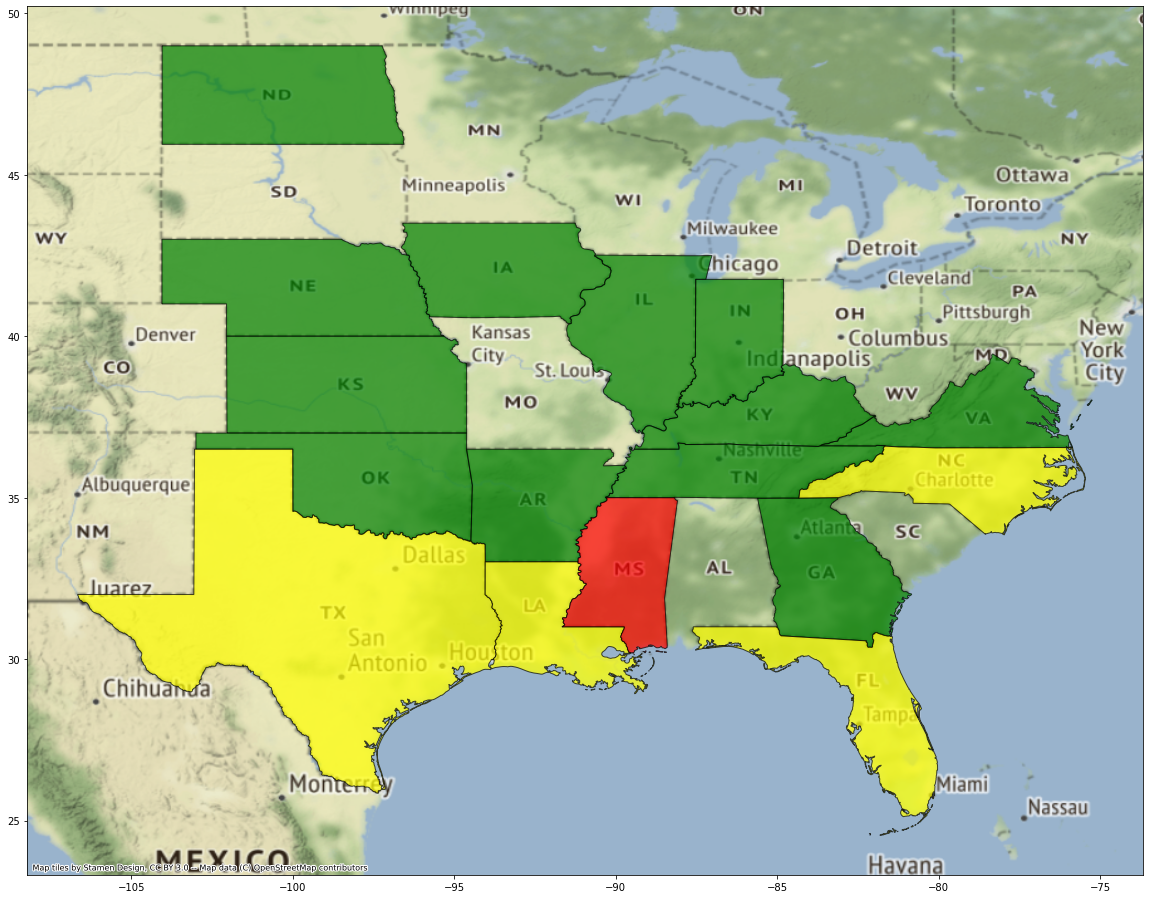

In [18]:
state_plotter(human_labeled_floods, '2019')

## human_labeled_damage map:

In [19]:
human_labeled_damage = merger(human_damage_label, image_metadata_gdf, 'url')

Low:  {'Georgia': 3, 'Virginia': 5, 'Oklahoma': 9, 'Arkansas': 34, 'Indiana': 2, 'Tennessee': 3, 'Kentucky': 2, 'Iowa': 12, 'Illinois': 10, 'Nebraska': 4, 'Kansas': 22, 'North Dakota': 13} 


Mid:  {'Texas': 216, 'Florida': 230, 'Louisiana': 89, 'Mississippi': 122} 


High:  {'North Carolina': 237}


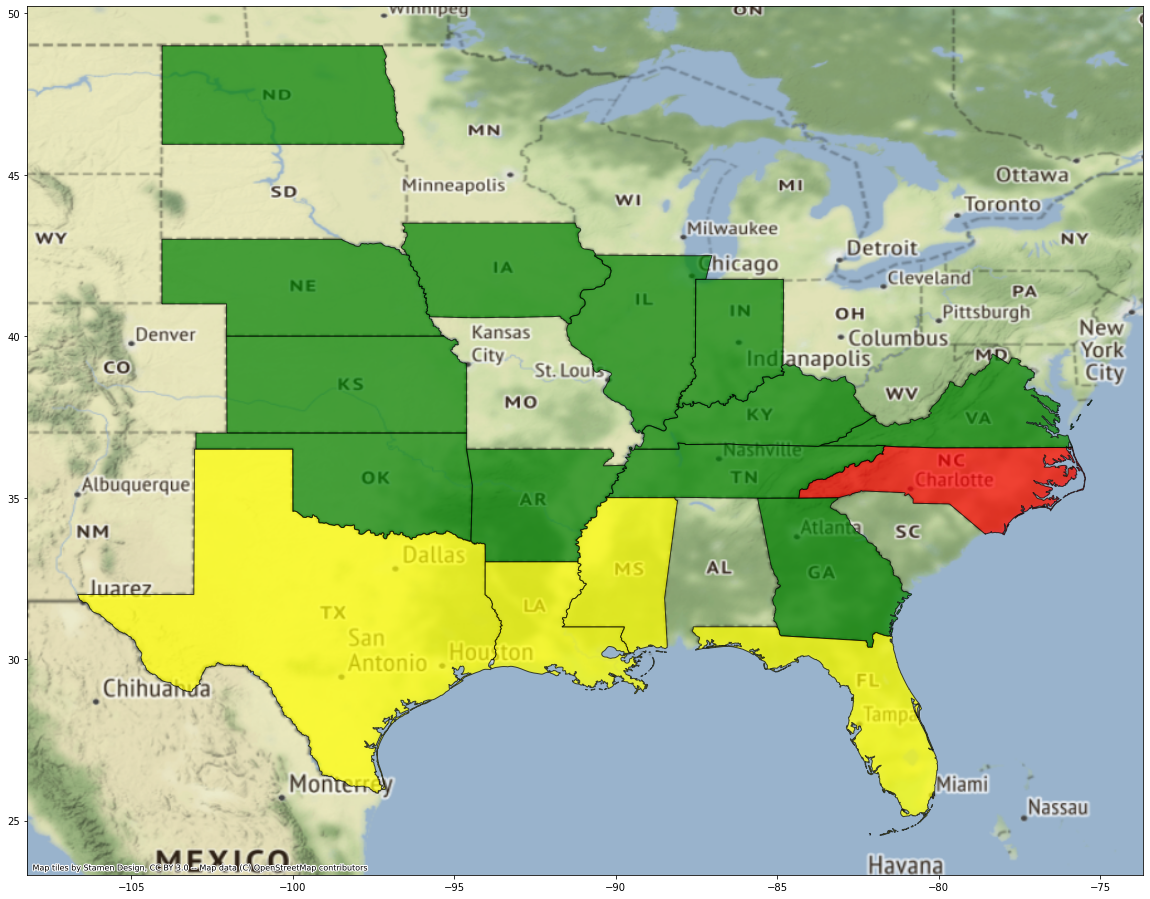

In [20]:
state_plotter(human_labeled_damage, '2019')